# XGBoost Architektur

#### Importe

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
from sklearn.model_selection import RandomizedSearchCV
from pathlib import Path

#### Import Plot Stylesheet

In [2]:
plt.style.use(['seaborn-v0_8-paper', Path.cwd().parent / 'plotstyle' / 'paper.mplstyle'])
cm = 1/2.54

#### Gleichgewichtsdaten importieren

In [3]:
eq_data_file = Path.cwd().parent / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten
res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und x gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Output x[H2,N2,NH3]
T = np.array(res['T'])
p = np.array(res['p'])
x_0 = np.array(res['x_0'])
x = np.array(res['x'])

#print(x_0)

X = np.stack((T, p, x_0[:,0], x_0[:,1], x_0[:,2]), axis = 1)
y = np.stack((x[:,0], x[:,2]), axis = 1) # [x_H2, x_NH3]
#print(X[:,0])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.8, random_state = 42)

#print(y_train)

#### Normalisierung

In [4]:
# Preprocessing Normalisierung der Daten
# mean_in = np.mean(X_train, 0) # Mittelwert
# std_in = np.std(X_train, 0) # Standardabweichung
# mean_out = np.mean(y_train, 0)
# std_out = np.std(y_train, 0)

# X_train = (X_train - mean_in) / std_in
# y_train = (y_train - mean_out) / std_out

# X_test = (X_test -mean_in) / std_in
# y_test = (y_test - mean_out) / std_out

# print(mean_in)
# print(std_in)
# print(X_train)
# print(np.mean(X_train[:,0]))

#### DMatrix

In [5]:
# Erstellen von Regressionsmatrizen
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

#### Hyperparameter

In [45]:
# Definition von Hyperparametern
params = {"objective": "reg:squarederror",
          "max_depth": 3, #default=6
          "learning_rate": 0.05, #default= 0.3
          "colsample_bytree": 0.8, #default=1 fraction of columns to be randomly sampled for each tree; might improve overfitting
          "eval_metric": ['mae','mape'],
          "subsample": 0.9, #default=1  fraction of observations to be sampled for each tree
          #"alpha": 1,
          "lambda": 2,
          #"gamma": 1
         }
evals = [(dtrain, "train"), (dtest, "validation")]

n = 10000 # Zahl der Boosting Rounds
evals_result = {} # Zur Speicherung des loss über die Boosting Rounds

#### XGBoost Modell

In [46]:
xgb_model = xgb.train(params = params, 
                      dtrain = dtrain, 
                      num_boost_round = n, 
                      evals = evals, 
                      verbose_eval = 20, # gibt nur alle x Runden aus
                      early_stopping_rounds = 50, # bricht Training ab, wenn val_loss sich für x Runden nicht verbessert
                      evals_result=evals_result
                     )

[0]	train-mae:0.23403	train-mape:2.30651	validation-mae:0.24137	validation-mape:1.99385
[20]	train-mae:0.09226	train-mape:0.96202	validation-mae:0.09645	validation-mape:0.81598
[40]	train-mae:0.03945	train-mape:0.42639	validation-mae:0.04290	validation-mape:0.35530
[60]	train-mae:0.01931	train-mape:0.20300	validation-mae:0.02327	validation-mape:0.17027
[80]	train-mae:0.01134	train-mape:0.10803	validation-mae:0.01560	validation-mape:0.09644
[100]	train-mae:0.00782	train-mape:0.06749	validation-mae:0.01213	validation-mape:0.06567
[120]	train-mae:0.00621	train-mape:0.04616	validation-mae:0.01042	validation-mape:0.04984
[140]	train-mae:0.00536	train-mape:0.03421	validation-mae:0.00955	validation-mape:0.04170
[160]	train-mae:0.00490	train-mape:0.02824	validation-mae:0.00910	validation-mape:0.03847
[180]	train-mae:0.00458	train-mape:0.02507	validation-mae:0.00877	validation-mape:0.03655
[200]	train-mae:0.00433	train-mape:0.02297	validation-mae:0.00856	validation-mape:0.03576
[220]	train-mae:

#### Plot der Lernkurven

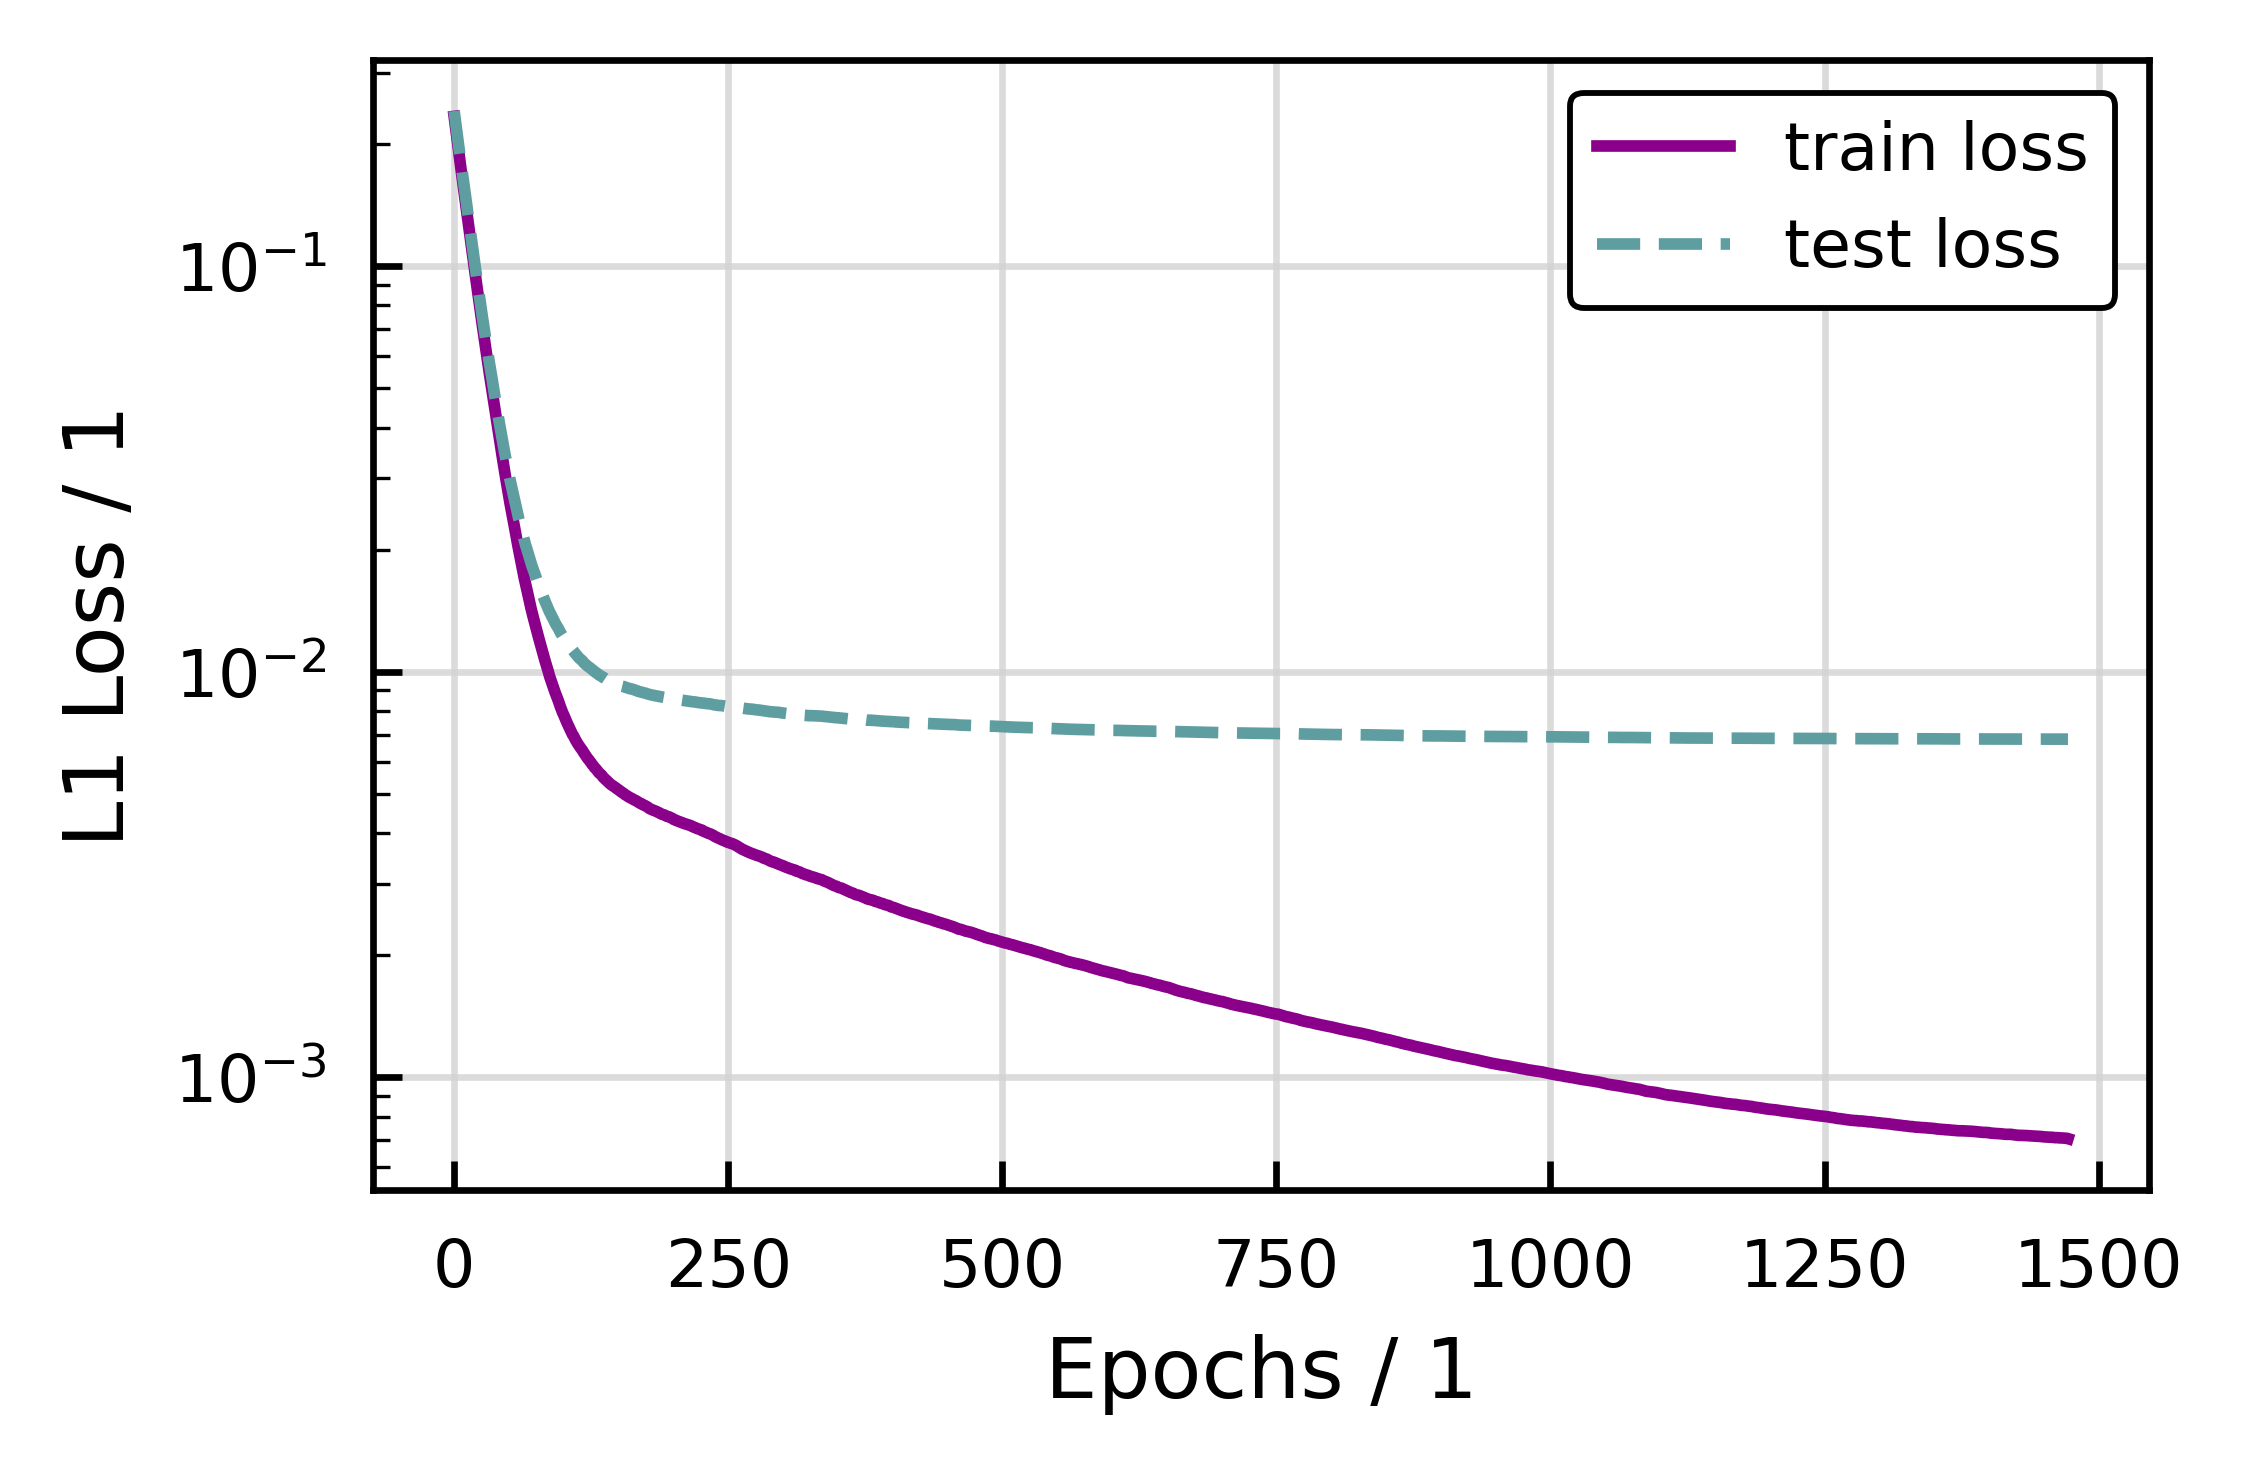

In [47]:
train_mae = (evals_result["train"]["mae"]) # 
test_mae = (evals_result["validation"]["mae"])
#print(test_mae)

fig,ax = plt.subplots(figsize=(9.75*cm,6.5*cm))
ax.semilogy(train_mae, label='train loss')
ax.semilogy(test_mae,'--', label='test loss')
#plt.title("Train and Test Loss")
ax.set(xlabel = 'Epochs / 1', ylabel = 'L1 Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)
#ax.set(xlim=(0,200), ylim=(1e-5,1e-1))

plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

#### Vorhersage Gleichgewichtsdaten

In [48]:
# Vorhersage der GGW Daten
pred_train = xgb_model.predict(dtrain)
pred_test = xgb_model.predict(dtest)
real_train = y_train
real_test = y_test
# # Denormalisierung
# pred_train = pred_train_norm * std_out + mean_out
# real_train = y_train * std_out + mean_out
# pred_test = pred_test_norm * std_out + mean_out
# real_test = y_test * std_out + mean_out

mae_train = (abs(real_train - pred_train)).mean()
mae_test = (abs(real_test - pred_test)).mean()
mre_train = (abs((real_train - pred_train) / real_train)).mean()
mre_test = (abs((real_test - pred_test) / real_test)).mean()

print('MAE Train:', mae_train, 'MRE Train:', mre_train, 'MAE Test:', mae_test, 'MRE Test:', mre_test)

MAE Train: 0.0007062889713772093 MRE Train: 0.003859770737742059 MAE Test: 0.00682123885234615 MRE Test: 0.02843288984634343


#### Parity Plot

Training Dataset: R^2 = 0.99993808288493
Test Dataset: R^2 = 0.9951313133934204
Max Error Training: |x_H2 - x_H2_pred| = 0.0014438890588792108 |x_NH3 - x_NH3_pred| = 0.0011632294327018622
Max Error Test: |x_H2 - x_H2_pred| = 0.006378106439032638 |x_NH3 - x_NH3_pred| = 0.02916198483311455


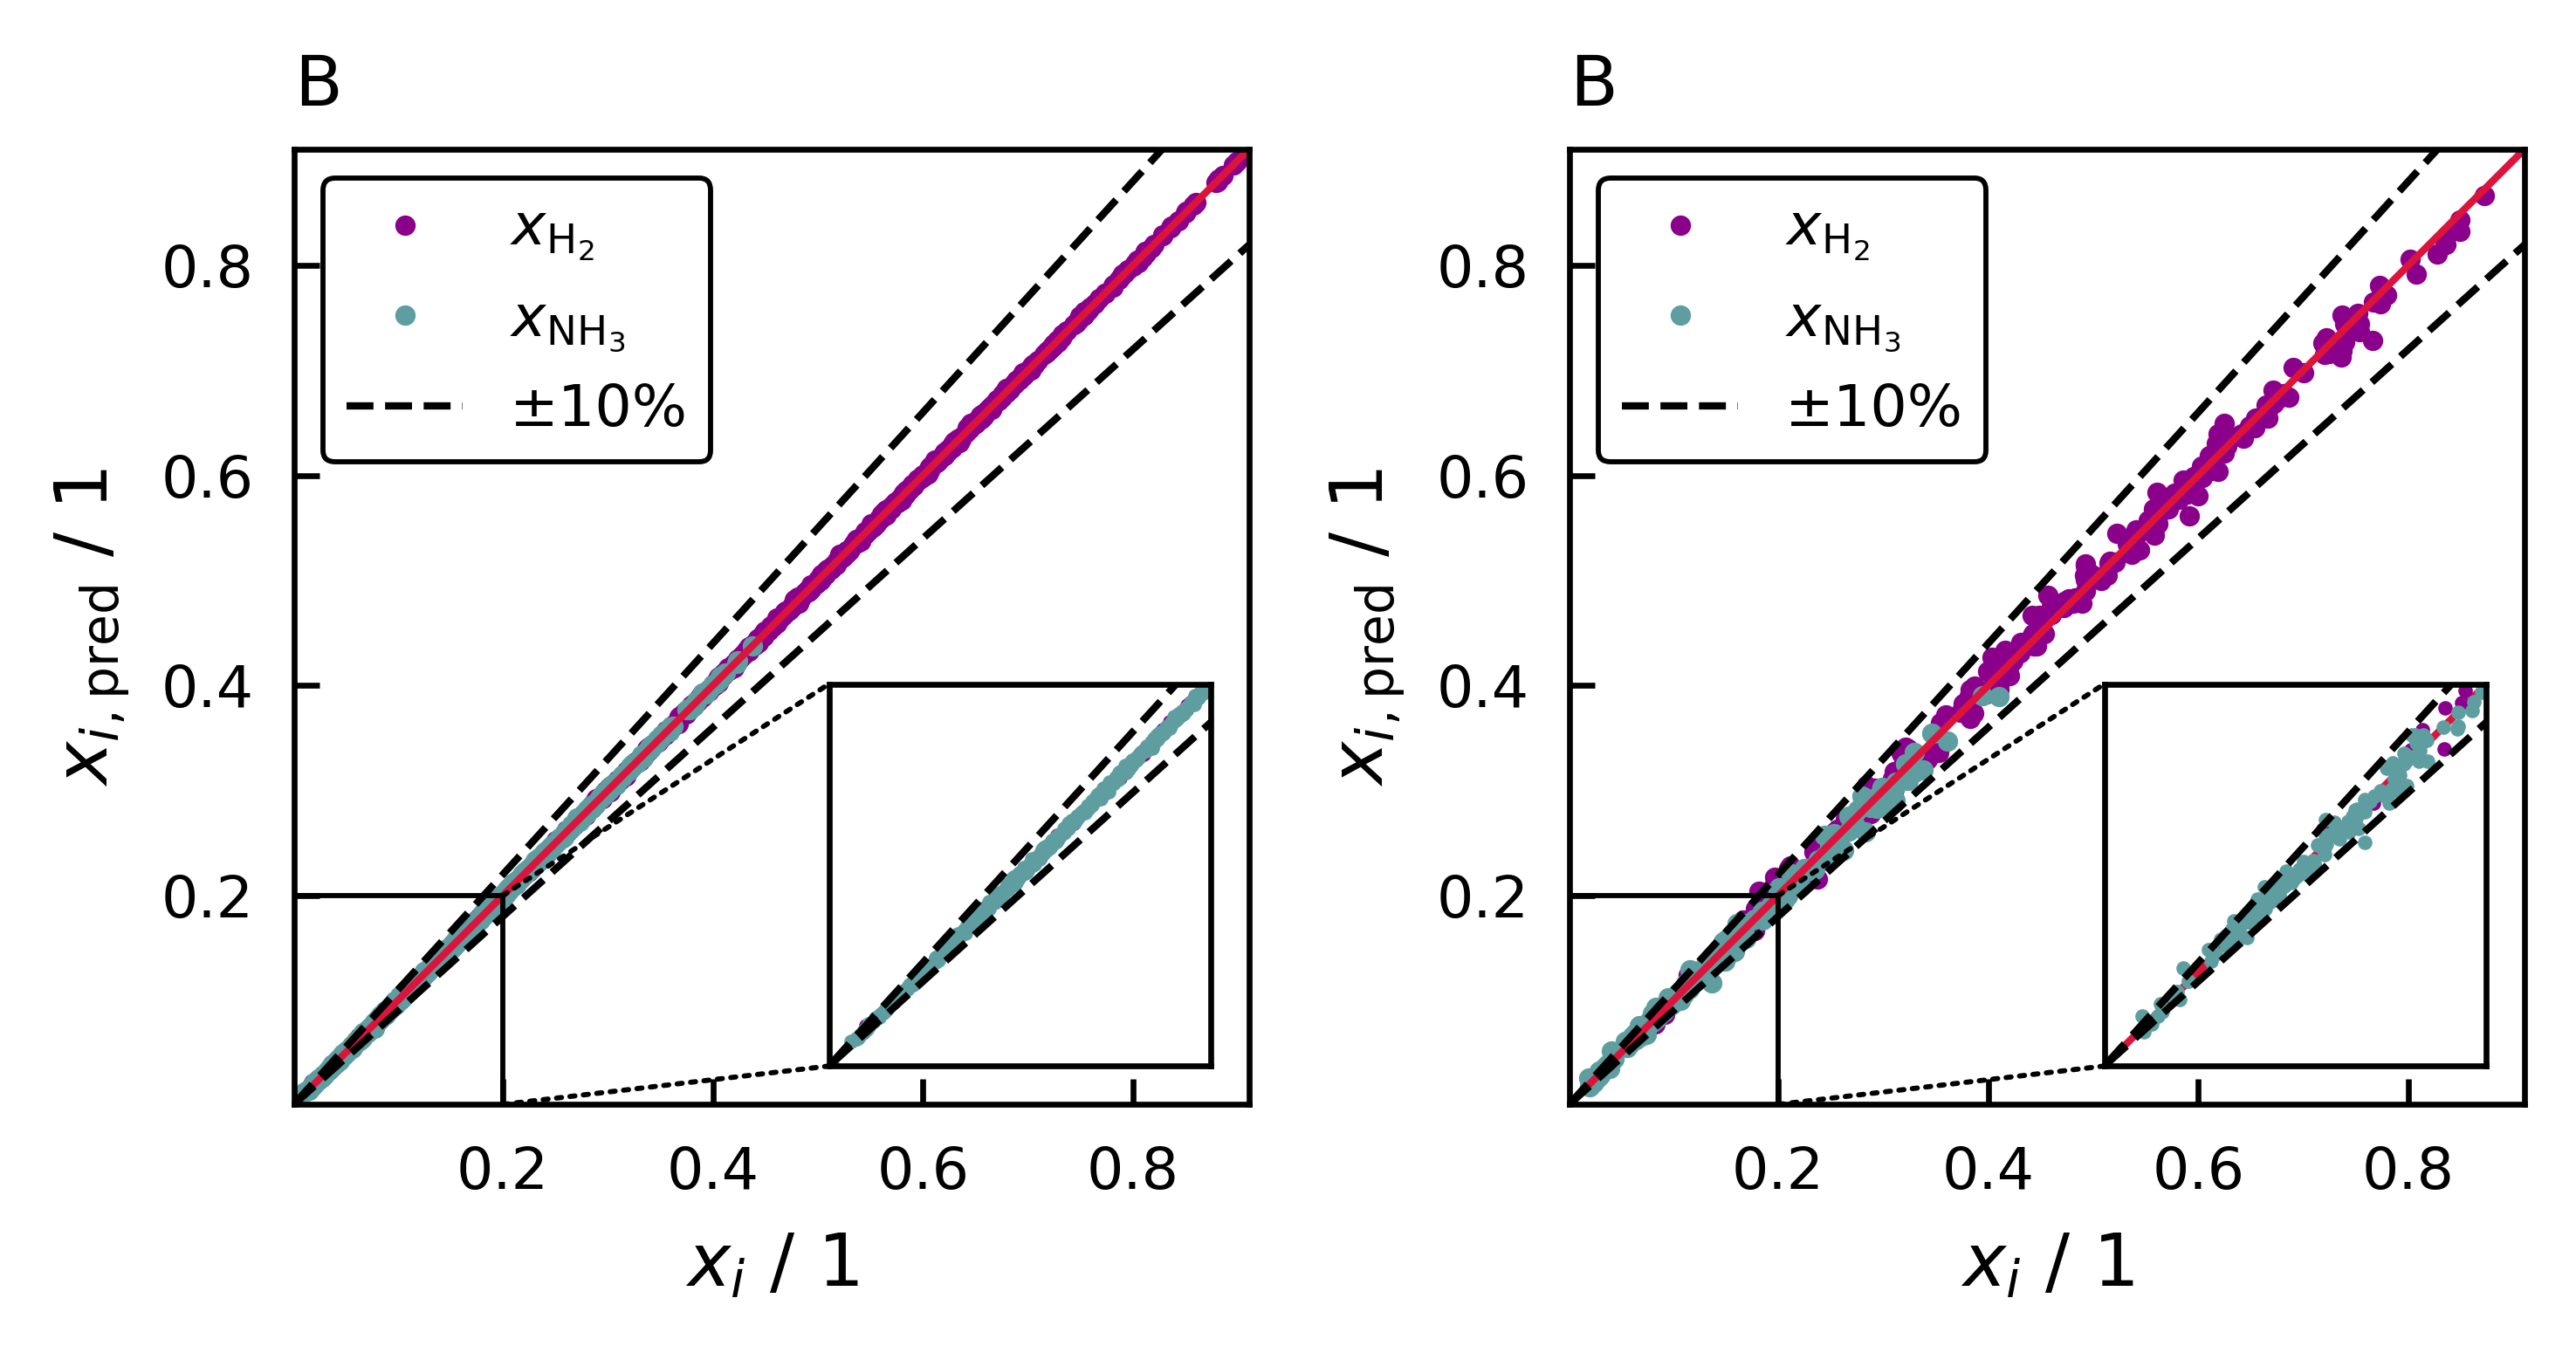

In [49]:
print('Training Dataset: R^2 =', r2(real_train,pred_train))
print('Test Dataset: R^2 =', r2(real_test,pred_test))
print('Max Error Training: |x_H2 - x_H2_pred| =', max_error(real_train[0], pred_train[0]), '|x_NH3 - x_NH3_pred| =', max_error(real_train[1], pred_train[1]))
print('Max Error Test: |x_H2 - x_H2_pred| =', max_error(real_test[0], pred_test[0]), '|x_NH3 - x_NH3_pred| =', max_error(real_test[1], pred_test[1]))

# find the boundaries of X and Y values
bounds = (min(real_train.min(), pred_train.min()) - int(0.1 * pred_train.min()), max(real_train.max(), pred_train.max())+ int(0.1 * pred_train.max()))

fig,ax = plt.subplots(1,2)#, figsize =(7.5*cm,7.5*cm))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(real_train, pred_train, '.', label = (['$x\mathregular{_{H_2}}$', '$x\mathregular{_{NH_3}}$']))
ax[0].plot([0, 1], [0, 1], "-", color = 'crimson', lw=1 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1]*1.1], "k--", lw=1, label = ('\xb1' '10%')) # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1]*0.9], "k--",lw=1) # Error line
ax[0].set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('B', loc='left')
ax[0].legend()

#inset axes
x1,x2,y1,y2 = 0, 0.2, 0, 0.2 # subregion of origanal image
axin0 = ax[0].inset_axes([0.56, 0.04, 0.4, 0.4], xlim=(x1,x2), ylim=(y1,y2), xticks=[], yticks=[], xticklabels=[], yticklabels=[])

axin0.plot(real_train, pred_train, '.', markersize = 4)
#axin0.plot(x_NH3_real, x_NH3_pred, '.', markersize = 4)
axin0.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1,zorder=1 )
axin0.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1)
axin0.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1)

rect = (x1, y1, x2 - x1, y2 - y1)
box2= ax[0].indicate_inset(rect, edgecolor="black", alpha=1,lw=0.7)

cp1 = ConnectionPatch(xyA=(0.2, 0.001), xyB=(0, 0), axesA=ax[0], axesB=axin0,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)
cp2 = ConnectionPatch(xyA=(0.2, 0.2), xyB=(0, 1), axesA=ax[0], axesB=axin0,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)

ax[0].add_patch(cp1)
ax[0].add_patch(cp2)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(real_test, pred_test, '.', label = (['$x\mathregular{_{H_2}}$', '$x\mathregular{_{NH_3}}$']))
ax[1].plot([0, 1], [0, 1], "-", color='crimson',lw=1 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1]*1.1], "k--", lw=1, label = ('\xb1' '10%')) # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1]*0.9], "k--",lw=1) # Error line
ax[1].set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('B', loc='left')
ax[1].legend()

#inset axes
x1,x2,y1,y2 = 0, 0.2, 0, 0.2 # subregion of origanal image
axin1 = ax[1].inset_axes([0.56, 0.04, 0.4, 0.4], xlim=(x1,x2), ylim=(y1,y2), xticks=[], yticks=[], xticklabels=[], yticklabels=[])

axin1.plot(real_test, pred_test, '.', markersize = 4)
#axin1.plot(x_NH3_real_test, x_NH3_pred_test, '.', markersize = 4)
axin1.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1,zorder=1 )
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1)
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1)

rect = (x1, y1, x2 - x1, y2 - y1)
box1= ax[1].indicate_inset(rect, edgecolor="black", alpha=1,lw=0.7)

cp1 = ConnectionPatch(xyA=(0.2, 0.001), xyB=(0, 0), axesA=ax[1], axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)
cp2 = ConnectionPatch(xyA=(0.2, 0.2), xyB=(0, 1), axesA=ax[1], axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)

ax[1].add_patch(cp1)
ax[1].add_patch(cp2)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Cross-Validation

In [9]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}
n = 1000

results = xgb.cv(
   params, dtrain,
   num_boost_round = n,
   nfold = 5,
   early_stopping_rounds = 20
)
print(results.head())

best_loss, best_round = results['test-rmse-mean'].min(), results['test-rmse-mean'].idxmin()
print('Best loss:', best_loss, 'Round:', best_round)

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         1.380653        0.007482        1.384559       0.035164
1         0.987312        0.005327        0.998745       0.027710
2         0.709325        0.003942        0.727808       0.022920
3         0.513083        0.002584        0.539768       0.019523
4         0.373660        0.002223        0.410636       0.017865
Best loss: 0.13619075966589303 Round: 118


#### RandomizedSearch CV

In [33]:
# Liste der zu tunenden Hyperparameter
params = {"objective": ["reg:squarederror", "reg:squaredlogerror", "reg:logistic", "reg:pseudohubererror", "reg:absoluteerror"],
          "max_depth": [3, 5, 6, 8, 10, 15], #default=6
          "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3, 0.4], #default= 0.3
          "colsample_bytree": np.arange(0.4, 1.0, 0.1), #default=1 fraction of columns to be randomly sampled for each tree; might improve overfitting
          "subsample": np.arange(0.5, 1.0, 0.1), #default=1  fraction of observations to be sampled for each tree
          "colsample_bylevel": np.arange(0.4, 1.0, 0.1),
          "n_estimators": np.arange(50, 1000, 10)
         }

# Neues XGBoost Objekt
knn_model_2 = xgb.XGBRegressor()

model = RandomizedSearchCV(knn_model_2, params, n_iter=25)
best_model = model.fit(X_train, y_train)

print('Best parameters:', best_model.best_params_)
best_objective = best_model.best_estimator_.get_params()['objective']
best_max_depth = best_model.best_estimator_.get_params()['max_depth']
best_learning_rate = best_model.best_estimator_.get_params()['learning_rate']
best_colsample_bytree = best_model.best_estimator_.get_params()['colsample_bytree']
best_subsample = best_model.best_estimator_.get_params()['subsample']
best_colsample_bylevel = best_model.best_estimator_.get_params()['colsample_bylevel']
best_n_estimators = best_model.best_estimator_.get_params()['n_estimators']

C:\Users\sinar\anaconda3\envs\BA\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sinar\anaconda3\envs\BA\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sinar\anaconda3\envs\BA\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\sinar\anaconda3\envs\BA\lib\site-packages\xgboost\sklearn.py", line 1025, in fit
    self._Booster = train(
  File "C:\Users\sinar\anaconda3\envs\BA\lib\

Best parameters: {'subsample': 0.7, 'objective': 'reg:squarederror', 'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.5}


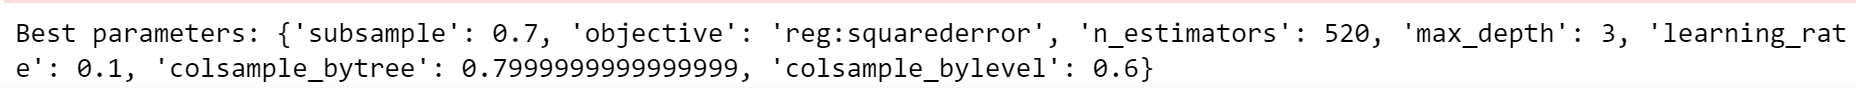!

#### Best Model

In [67]:
evals_result = {}
# Definition von Hyperparametern
best_params = {"objective": "reg:squarederror",
          "max_depth": 3, #default=6
          "learning_rate": 0.1, #default= 0.3
          "colsample_bytree": 0.8, #default=1 fraction of columns to be randomly sampled for each tree; might improve overfitting
          "colsample_bylevel" : 0.6,
          "eval_metric": ['mae','mape'],
          "subsample": 0.7, #default=1  fraction of observations to be sampled for each tree
         }
xgb_model_2 = xgb.train(params = best_params, 
                      dtrain = dtrain, 
                      num_boost_round = 4000, 
                      evals = evals, 
                      verbose_eval = 50, # gibt nur alle x Runden aus
                      early_stopping_rounds = 50, # bricht Training ab, wenn val_loss sich für x Runden nicht verbessert
                      evals_result=evals_result
                    )

# xgb_model_2 = xgb.train(params = best_model.best_params_, 
#                       dtrain = dtrain, 
#                       num_boost_round = 4000, 
#                       evals = evals, 
#                       verbose_eval = 50, # gibt nur alle x Runden aus
#                       early_stopping_rounds = 50, # bricht Training ab, wenn val_loss sich für x Runden nicht verbessert
#                       evals_result=evals_result
#                     )

[0]	train-mae:1.46262	train-mape:1.75056	validation-mae:1.49781	validation-mape:2.15184
[50]	train-mae:0.08146	train-mape:0.26485	validation-mae:0.10909	validation-mape:0.47065
[100]	train-mae:0.05077	train-mape:0.18801	validation-mae:0.07702	validation-mape:0.31325
[150]	train-mae:0.04157	train-mape:0.15123	validation-mae:0.07047	validation-mape:0.28440
[200]	train-mae:0.03450	train-mape:0.12205	validation-mae:0.06681	validation-mape:0.25565
[241]	train-mae:0.03000	train-mape:0.09978	validation-mae:0.06420	validation-mape:0.25015


#### Plot Lernkurve

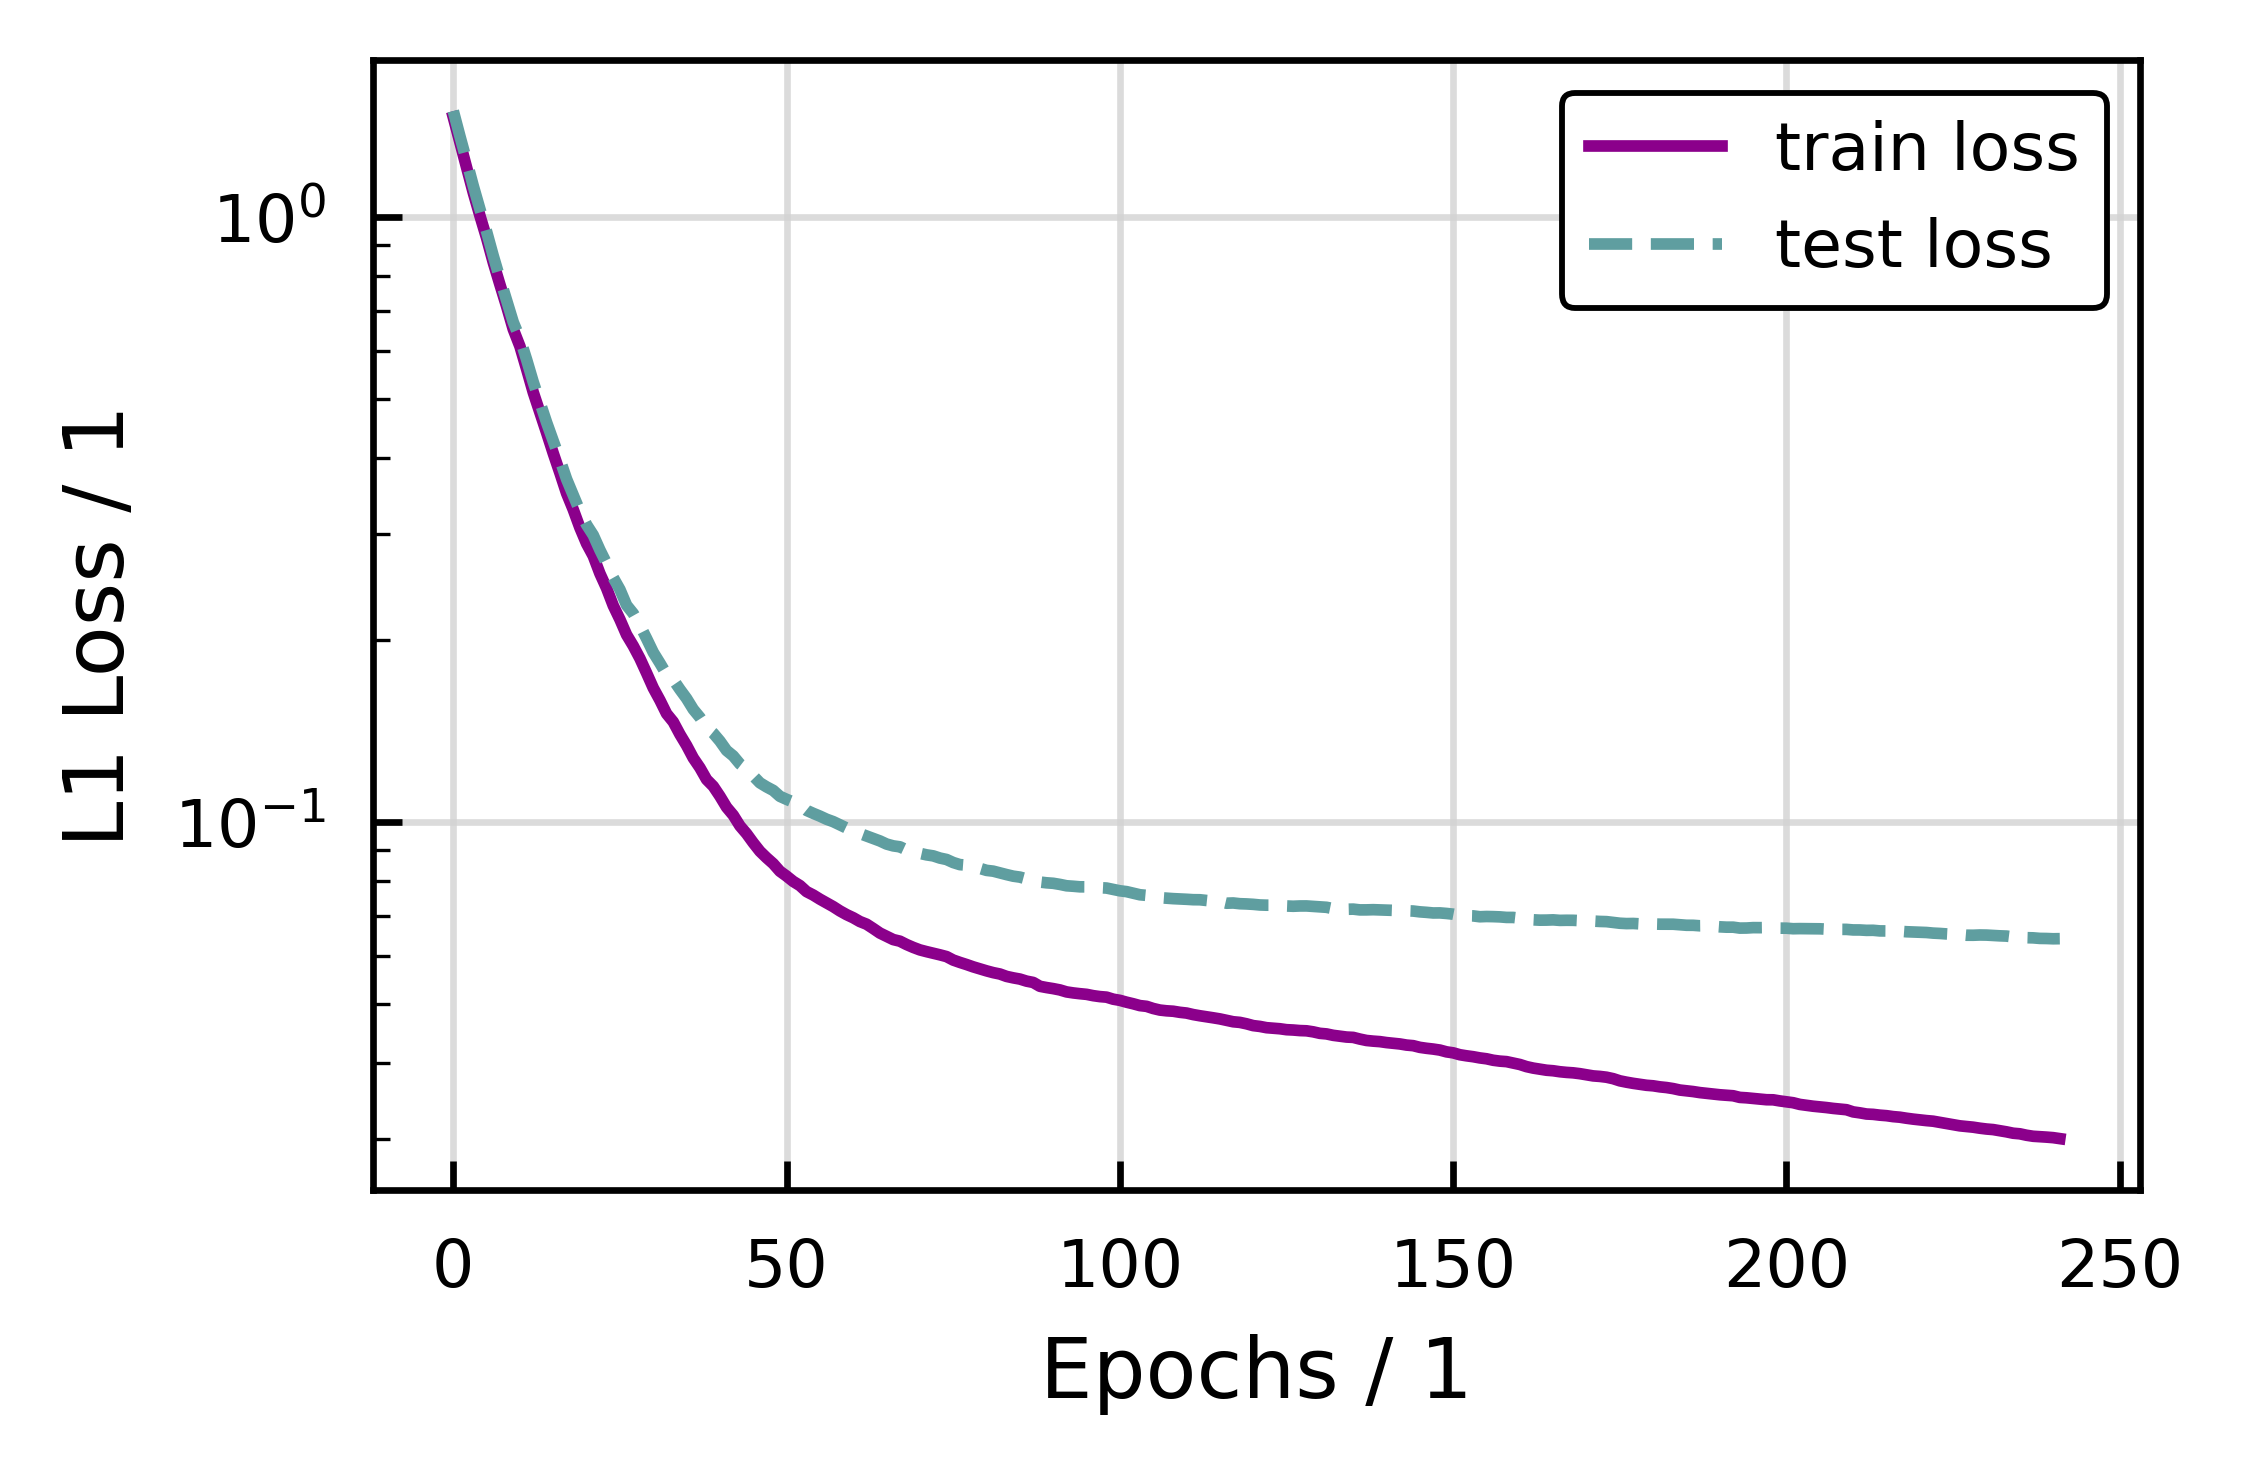

In [68]:
train_mae = (evals_result["train"]["mae"]) # 
test_mae = (evals_result["validation"]["mae"])
#print(test_mae)

fig,ax = plt.subplots(figsize=(9.75*cm,6.5*cm))
ax.semilogy(train_mae, label='train loss')
ax.semilogy(test_mae,'--', label='test loss')
#plt.title("Train and Test Loss")
ax.set(xlabel = 'Epochs / 1', ylabel = 'L1 Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)
#ax.set(xlim=(0,200), ylim=(1e-5,1e-1))

plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [69]:
# Vorhersage der GGW Daten
pred_train_norm = xgb_model_2.predict(dtrain)
pred_test_norm = xgb_model_2.predict(dtest)

# Denormalisierung
pred_train = pred_train_norm * std_out + mean_out
real_train = y_train * std_out + mean_out
pred_test = pred_test_norm * std_out + mean_out
real_test = y_test * std_out + mean_out

mae_train = (abs(real_train - pred_train)).mean()
mae_test = (abs(real_test - pred_test)).mean()
mre_train = (abs((real_train - pred_train) / real_train)).mean()
mre_test = (abs((real_test - pred_test) / real_test)).mean()

print('MAE Train:', mae_train, 'MRE Train:', mre_train, 'MAE Test:', mae_test, 'MRE Test:', mre_test)

MAE Train: 0.0038539592381289563 MRE Train: 0.019973107311520234 MAE Test: 0.008118681342193543 MRE Test: 0.03961854479343102


Training Dataset: R^2 = 0.9984318281920443
Test Dataset: R^2 = 0.9916330864238616
Max Error Training: |x_H2 - x_H2_pred| = 0.005876668906428628 |x_NH3 - x_NH3_pred| = 0.006649820017460839
Max Error Test: |x_H2 - x_H2_pred| = 0.008605089415473055 |x_NH3 - x_NH3_pred| = 0.023967857601185416


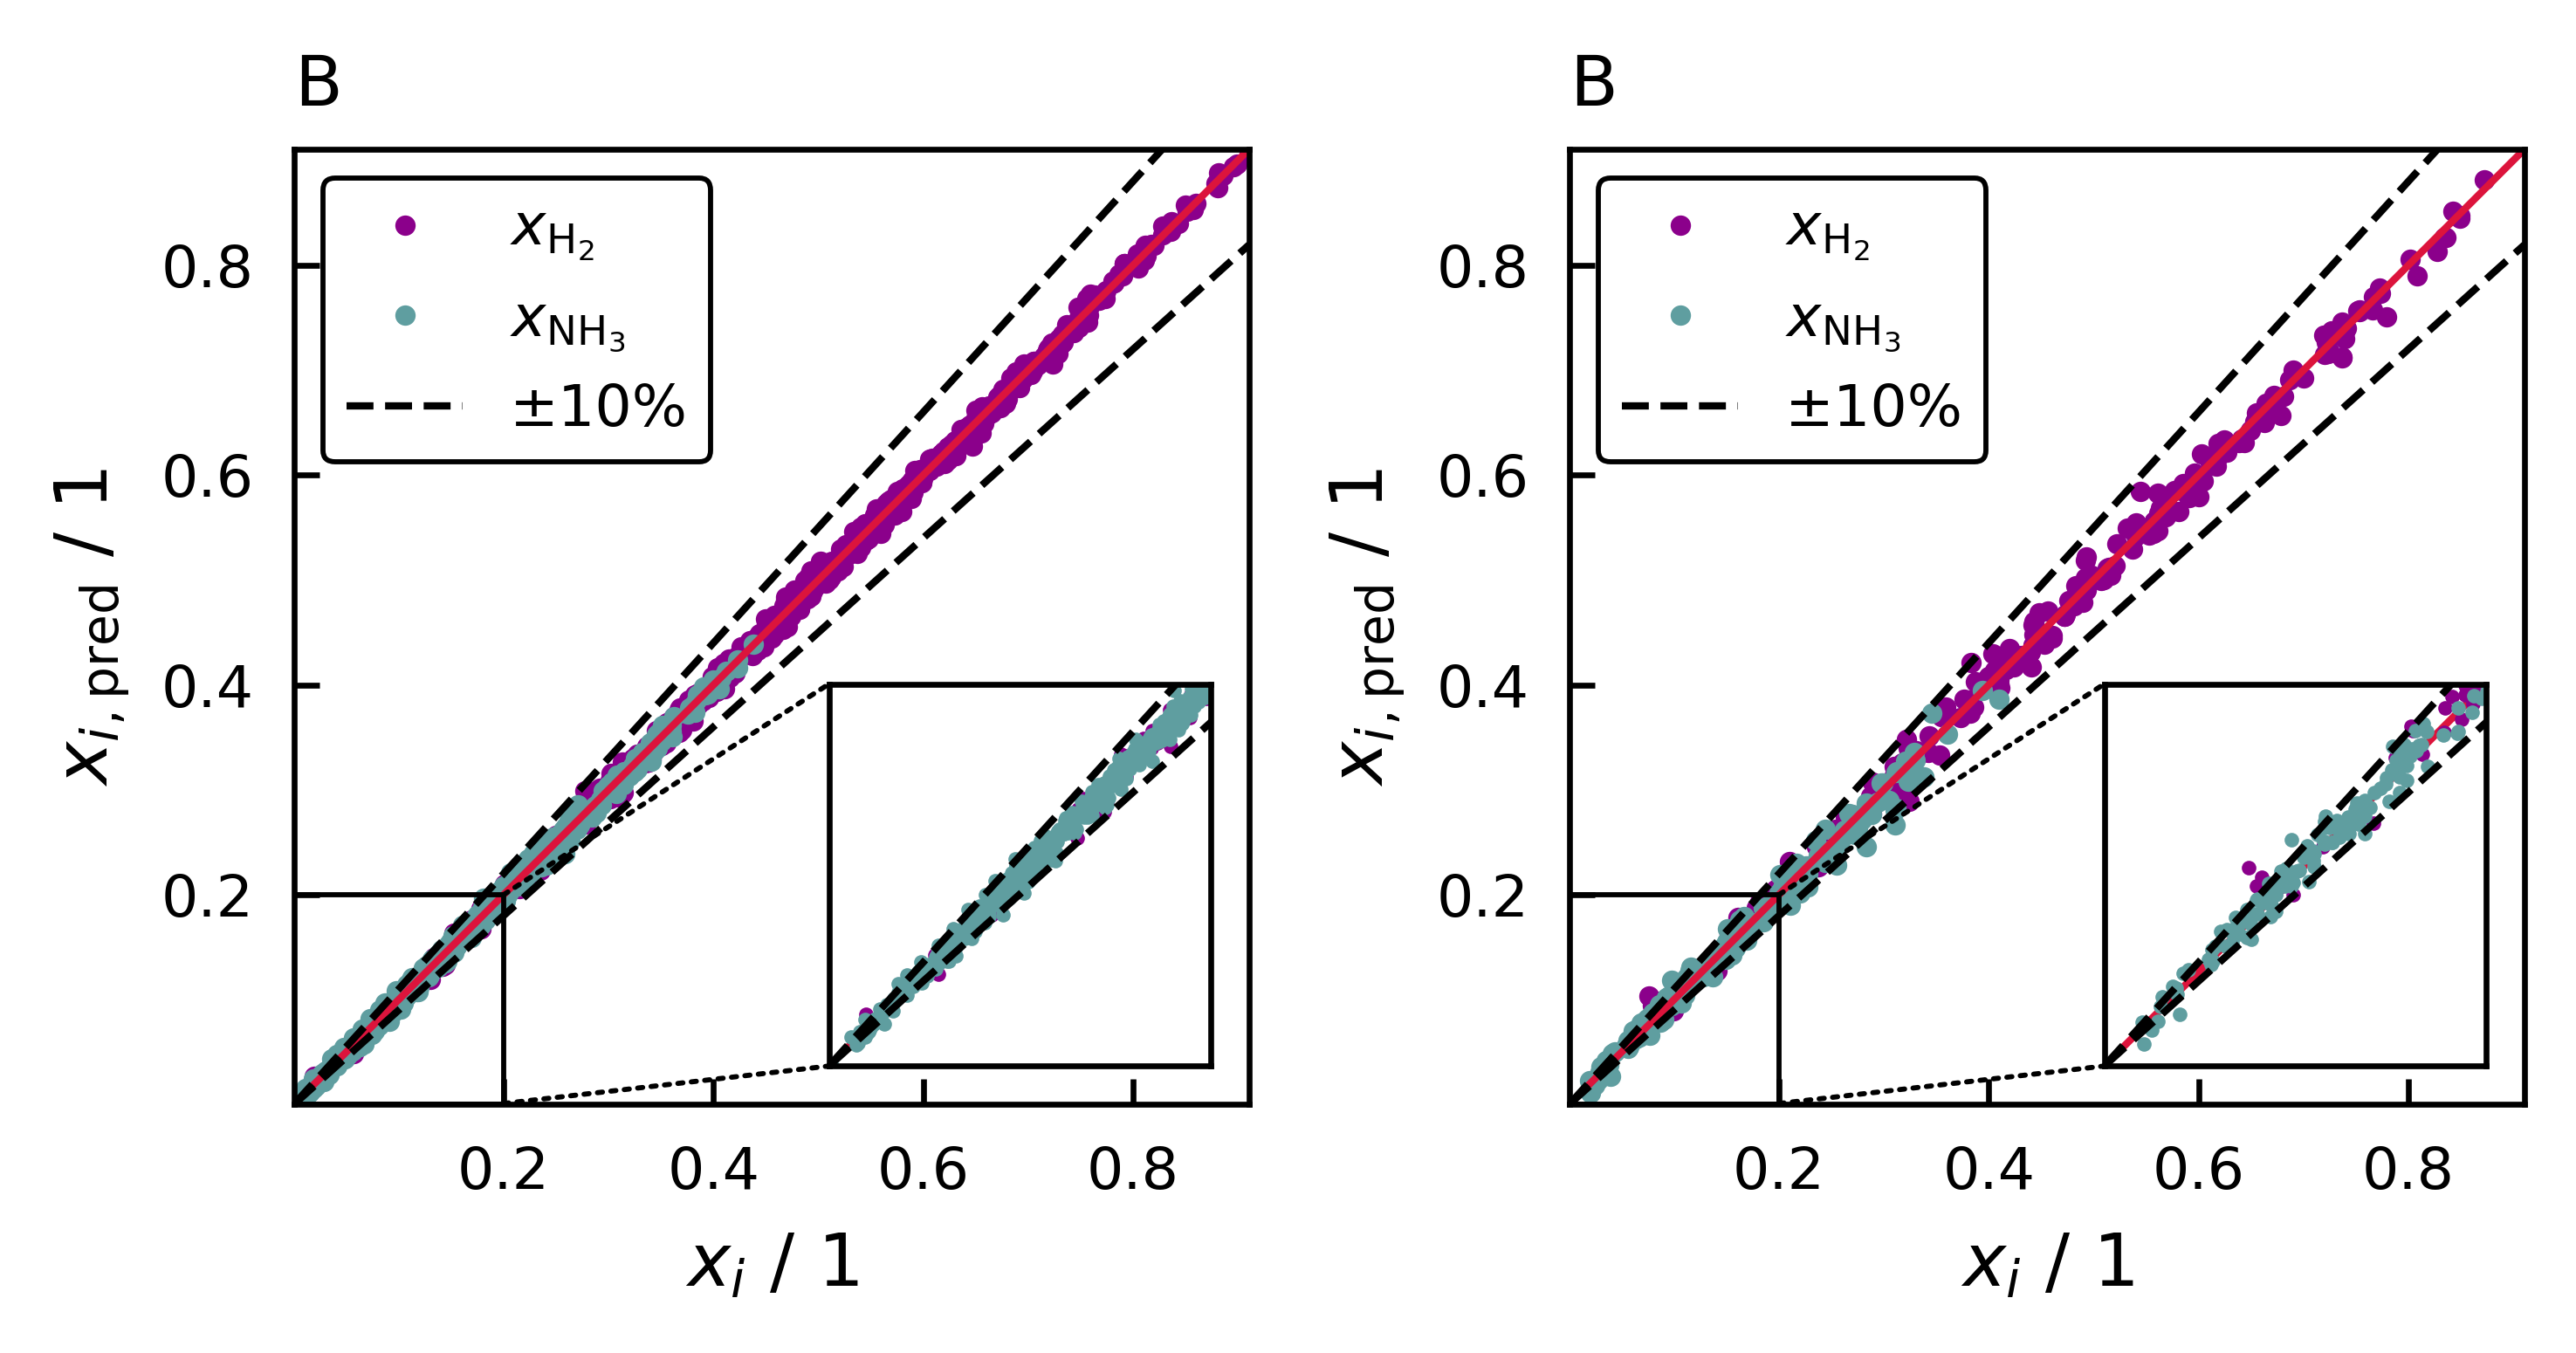

In [70]:
print('Training Dataset: R^2 =', r2(real_train,pred_train))
print('Test Dataset: R^2 =', r2(real_test,pred_test))
print('Max Error Training: |x_H2 - x_H2_pred| =', max_error(real_train[0], pred_train[0]), '|x_NH3 - x_NH3_pred| =', max_error(real_train[1], pred_train[1]))
print('Max Error Test: |x_H2 - x_H2_pred| =', max_error(real_test[0], pred_test[0]), '|x_NH3 - x_NH3_pred| =', max_error(real_test[1], pred_test[1]))

# find the boundaries of X and Y values
bounds = (min(real_train.min(), pred_train.min()) - int(0.1 * pred_train.min()), max(real_train.max(), pred_train.max())+ int(0.1 * pred_train.max()))

fig,ax = plt.subplots(1,2)#, figsize =(7.5*cm,7.5*cm))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(real_train, pred_train, '.', label = (['$x\mathregular{_{H_2}}$', '$x\mathregular{_{NH_3}}$']))
ax[0].plot([0, 1], [0, 1], "-", color = 'crimson', lw=1 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1]*1.1], "k--", lw=1, label = ('\xb1' '10%')) # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1]*0.9], "k--",lw=1) # Error line
ax[0].set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('B', loc='left')
ax[0].legend()

#inset axes
x1,x2,y1,y2 = 0, 0.2, 0, 0.2 # subregion of origanal image
axin0 = ax[0].inset_axes([0.56, 0.04, 0.4, 0.4], xlim=(x1,x2), ylim=(y1,y2), xticks=[], yticks=[], xticklabels=[], yticklabels=[])

axin0.plot(real_train, pred_train, '.', markersize = 4)
#axin0.plot(x_NH3_real, x_NH3_pred, '.', markersize = 4)
axin0.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1,zorder=1 )
axin0.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1)
axin0.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1)

rect = (x1, y1, x2 - x1, y2 - y1)
box2= ax[0].indicate_inset(rect, edgecolor="black", alpha=1,lw=0.7)

cp1 = ConnectionPatch(xyA=(0.2, 0.001), xyB=(0, 0), axesA=ax[0], axesB=axin0,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)
cp2 = ConnectionPatch(xyA=(0.2, 0.2), xyB=(0, 1), axesA=ax[0], axesB=axin0,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)

ax[0].add_patch(cp1)
ax[0].add_patch(cp2)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(real_test, pred_test, '.', label = (['$x\mathregular{_{H_2}}$', '$x\mathregular{_{NH_3}}$']))
ax[1].plot([0, 1], [0, 1], "-", color='crimson',lw=1 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1]*1.1], "k--", lw=1, label = ('\xb1' '10%')) # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1]*0.9], "k--",lw=1) # Error line
ax[1].set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('B', loc='left')
ax[1].legend()

#inset axes
x1,x2,y1,y2 = 0, 0.2, 0, 0.2 # subregion of origanal image
axin1 = ax[1].inset_axes([0.56, 0.04, 0.4, 0.4], xlim=(x1,x2), ylim=(y1,y2), xticks=[], yticks=[], xticklabels=[], yticklabels=[])

axin1.plot(real_test, pred_test, '.', markersize = 4)
#axin1.plot(x_NH3_real_test, x_NH3_pred_test, '.', markersize = 4)
axin1.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1,zorder=1 )
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1)
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1)

rect = (x1, y1, x2 - x1, y2 - y1)
box1= ax[1].indicate_inset(rect, edgecolor="black", alpha=1,lw=0.7)

cp1 = ConnectionPatch(xyA=(0.2, 0.001), xyB=(0, 0), axesA=ax[1], axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)
cp2 = ConnectionPatch(xyA=(0.2, 0.2), xyB=(0, 1), axesA=ax[1], axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)

ax[1].add_patch(cp1)
ax[1].add_patch(cp2)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [22]:
#xgb_model.save_model(Path.cwd().parent / 'data' / 'models' / 'xgb_011_014.json')
#np.savez(Path.cwd().parent / 'data/models/params_011_014.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)